In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import matplotlib.mlab as mlab
from Optimizers.Vprop4 import Vprop as Vprop
from Optimizers.noisyAdam import noisyAdam as noisyAdam
from Utilities.create_dataloaders import create_dataloaders 

### **Quick Note:**

#### This Experiment Notebook is to analyze how different VI optimizers behave in a simple linear regression model. It's worth playing with the initialization scheme, the W distribution center, noise, as well as the hyperparameters of the optimizers. Note that when we define the W mu and the Initialization on top of each other (e.g. at 0), Vprop and Noisy Adam experience a jump in error during the 1st iteration. However, when the W mu and the weight initialization are apart from each other this does not occur - we haven't been able to pin-point the cause. Also note that restricting Vprop's alpha a few decimals closer to 1 (e.g. 0.99 -> 0.999) can result in drastic improvements in capturing the variance of the true weights. 

### To Do: ###

##### [ ] Add different models: simple MLP benchmark model that has been used in recent neural optimization literature
##### [ ] Add PSIS paper diagnostics to measure how well the VI optimizers capture the posterior 
##### [ ] Add full Covariance Matrices to see if K-FAC variants capture weight correlations
##### [ ] Experiment with bi-modal weight (or more complex like hierarchical) distributions to see how well the optimizers capture these dists

In [19]:
#def neg_logliklihood(w_hat, X, y):
#    """Computes the negative log-likelihood as a function 
#       of w_hat (/theta) for a fixed <X,y> data pair. 
#       this is needed for computing the importance ratios
#       in Aki's PSIS paper"""
#    N   = len(y)
#    mu  = X@w_hat
#    var = ((y - X@w_hat)**2).sum()/N
#    return -1*norm(mu, math.sqrt(var)).logpdf(y).sum()


def psis_diagnostic(num_samples, q_samples, q_mu, q_simga, NLL):
    """Algorithm 1 from Aki et al 2018 which uses
       PSIS (Pareto Smooth Importance Sampling) to
       diagnose the quality of the variational 
       approximation to the posterior"""
    
    # Initialize vars
    sample_dim = len(q_mu[0])
    r = np.ndarray((sample_dim, num_samples))
    print(r.shape)
    
    # 1. create q_theta distribution
    q = norm(q_mu, q_sigma) 
    
    # 2. create prior distribution
    prior = norm(0,1)
    
    # 3. compute importance ratios
    for i in range(num_samples):
        r[:,i] = -NLL[i] + prior.logpdf(q_samples[:,i]) /  q.logpdf(q_samples[:,i])
        
    # 4. fit pareto
    lw_out, kss = psislw(r)
    
    # 5. report goodness of fit
    print("PSIS K value is: ", kss)
    
    return lw_out, kss
    
def psislw(lw, Reff=1.0, overwrite_lw=False):
    """Pareto smoothed importance sampling (PSIS).
    Parameters
    ----------
    lw : ndarray
        Array of size n x m containing m sets of n log weights. It is also
        possible to provide one dimensional array of length n.
    Reff : scalar, optional
        relative MCMC efficiency ``N_eff / N``
    overwrite_lw : bool, optional
        If True, the input array `lw` is smoothed in-place, assuming the array
        is F-contiguous. By default, a new array is allocated.
    Returns
    -------
    lw_out : ndarray
        smoothed log weights
    kss : ndarray
        Pareto tail indices
    """
    if lw.ndim == 2:
        n, m = lw.shape
    elif lw.ndim == 1:
        n = len(lw)
        m = 1
    else:
        raise ValueError("Argument `lw` must be 1 or 2 dimensional.")
    if n <= 1:
        raise ValueError("More than one log-weight needed.")

    if overwrite_lw and lw.flags.f_contiguous:
        # in-place operation
        lw_out = lw
    else:
        # allocate new array for output
        lw_out = np.copy(lw, order='F')

    # allocate output array for kss
    kss = np.empty(m)

    # precalculate constants
    cutoff_ind = - int(np.ceil(min(0.2 * n, 3 * np.sqrt(n / Reff)))) - 1
    cutoffmin = np.log(np.finfo(float).tiny)
    logn = np.log(n)
    k_min = 1/3

    # loop over sets of log weights
    for i, x in enumerate(lw_out.T if lw_out.ndim == 2 else lw_out[None, :]):
        # improve numerical accuracy
        x -= np.max(x)
        # sort the array
        x_sort_ind = np.argsort(x)
        # divide log weights into body and right tail
        xcutoff = max(
            x[x_sort_ind[cutoff_ind]],
            cutoffmin
        )
        expxcutoff = np.exp(xcutoff)
        tailinds, = np.where(x > xcutoff)
        x2 = x[tailinds]
        n2 = len(x2)
        if n2 <= 4:
            # not enough tail samples for gpdfitnew
            k = np.inf
        else:
            # order of tail samples
            x2si = np.argsort(x2)
            # fit generalized Pareto distribution to the right tail samples
            np.exp(x2, out=x2)
            x2 -= expxcutoff
            k, sigma = gpdfitnew(x2, sort=x2si)
        if k >= k_min and not np.isinf(k):
            # no smoothing if short tail or GPD fit failed
            # compute ordered statistic for the fit
            sti = np.arange(0.5, n2)
            sti /= n2
            qq = gpinv(sti, k, sigma)
            qq += expxcutoff
            np.log(qq, out=qq)
            # place the smoothed tail into the output array
            x[tailinds[x2si]] = qq
            # truncate smoothed values to the largest raw weight 0
            x[x > 0] = 0
        # renormalize weights
        x -= sumlogs(x)
        # store tail index k
        kss[i] = k

    # If the provided input array is one dimensional, return kss as scalar.
    if lw_out.ndim == 1:
        kss = kss[0]

    return lw_out, kss


def gpdfitnew(x, sort=True, sort_in_place=False, return_quadrature=False):
    """Estimate the paramaters for the Generalized Pareto Distribution (GPD)
    Returns empirical Bayes estimate for the parameters of the two-parameter
    generalized Parato distribution given the data.
    Parameters
    ----------
    x : ndarray
        One dimensional data array
    sort : bool or ndarray, optional
        If known in advance, one can provide an array of indices that would
        sort the input array `x`. If the input array is already sorted, provide
        False. If True (default behaviour), the array is sorted internally.
    sort_in_place : bool, optional
        If `sort` is True and `sort_in_place` is True, the array is sorted
        in-place (False by default).
    return_quadrature : bool, optional
        If True, quadrature points and weight `ks` and `w` of the marginal posterior distribution of k are also calculated and returned. False by
        default.
    Returns
    -------
    k, sigma : float
        estimated parameter values
    ks, w : ndarray
        Quadrature points and weights of the marginal posterior distribution
        of `k`. Returned only if `return_quadrature` is True.
    Notes
    -----
    This function returns a negative of Zhang and Stephens's k, because it is
    more common parameterisation.
    """
    if x.ndim != 1 or len(x) <= 1:
        raise ValueError("Invalid input array.")

    # check if x should be sorted
    if sort is True:
        if sort_in_place:
            x.sort()
            xsorted = True
        else:
            sort = np.argsort(x)
            xsorted = False
    elif sort is False:
        xsorted = True
    else:
        xsorted = False

    n = len(x)
    PRIOR = 3
    m = 30 + int(np.sqrt(n))

    bs = np.arange(1, m + 1, dtype=float)
    bs -= 0.5
    np.divide(m, bs, out=bs)
    np.sqrt(bs, out=bs)
    np.subtract(1, bs, out=bs)
    if xsorted:
        bs /= PRIOR * x[int(n/4 + 0.5) - 1]
        bs += 1 / x[-1]
    else:
        bs /= PRIOR * x[sort[int(n/4 + 0.5) - 1]]
        bs += 1 / x[sort[-1]]

    ks = np.negative(bs)
    temp = ks[:,None] * x
    np.log1p(temp, out=temp)
    np.mean(temp, axis=1, out=ks)

    L = bs / ks
    np.negative(L, out=L)
    np.log(L, out=L)
    L -= ks
    L -= 1
    L *= n

    temp = L - L[:,None]
    np.exp(temp, out=temp)
    w = np.sum(temp, axis=1)
    np.divide(1, w, out=w)

    # remove negligible weights
    dii = w >= 10 * np.finfo(float).eps
    if not np.all(dii):
        w = w[dii]
        bs = bs[dii]
    # normalise w
    w /= w.sum()

    # posterior mean for b
    b = np.sum(bs * w)
    # Estimate for k, note that we return a negative of Zhang and
    # Stephens's k, because it is more common parameterisation.
    temp = (-b) * x
    np.log1p(temp, out=temp)
    k = np.mean(temp)
    if return_quadrature:
        np.negative(x, out=temp)
        temp = bs[:, None] * temp
        np.log1p(temp, out=temp)
        ks = np.mean(temp, axis=1)
    # estimate for sigma
    sigma = -k / b * n / (n - 0)
    # weakly informative prior for k
    a = 10
    k = k * n / (n+a) + a * 0.5 / (n+a)
    if return_quadrature:
        ks *= n / (n+a)
        ks += a * 0.5 / (n+a)

    if return_quadrature:
        return k, sigma, ks, w
    else:
        return k, sigma


def gpinv(p, k, sigma):
    """Inverse Generalised Pareto distribution function."""
    x = np.empty(p.shape)
    x.fill(np.nan)
    if sigma <= 0:
        return x
    ok = (p > 0) & (p < 1)
    if np.all(ok):
        if np.abs(k) < np.finfo(float).eps:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            np.negative(x, out=x)
        else:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            x *= -k
            np.expm1(x, out=x)
            x /= k
        x *= sigma
    else:
        if np.abs(k) < np.finfo(float).eps:
            # x[ok] = - np.log1p(-p[ok])
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            np.negative(temp, out=temp)
            x[ok] = temp
        else:
            # x[ok] = np.expm1(-k * np.log1p(-p[ok])) / k
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            temp *= -k
            np.expm1(temp, out=temp)
            temp /= k
            x[ok] = temp
        x *= sigma
        x[p == 0] = 0
        if k >= 0:
            x[p == 1] = np.inf
        else:
            x[p == 1] = -sigma / k
    return x


def sumlogs(x, axis=None, out=None):
    """Sum of vector where numbers are represented by their logarithms.
    Calculates ``np.log(np.sum(np.exp(x), axis=axis))`` in such a fashion that
    it works even when elements have large magnitude.
    """
    maxx = x.max(axis=axis, keepdims=True)
    xnorm = x - maxx
    np.exp(xnorm, out=xnorm)
    out = np.sum(xnorm, axis=axis, out=out)
    if isinstance(out, np.ndarray):
        np.log(out, out=out)
    else:
        out = np.log(out)
    out += np.squeeze(maxx)
    return out

### 1. Sample Weights from predefined Distribution

In [3]:
# Diagonal Covariance Matrix

dim   = 1000       # <========= Define number of parameters
mu    = 0          
sigma = 1
S     = np.diag([sigma]*dim)

w = np.random.multivariate_normal( [mu]*dim, S )
w = np.asarray(w, dtype=np.float32).reshape(-1,1)
w.shape

(1000, 1)

### 2. Sample Input Features from predefined Distribution

In [4]:
sigma_x = 3
num_samples = dim +1

features = []
for i in range(num_samples):
    features.append( [np.random.randn(dim)*sigma_x] )
    
X = np.asarray(features, dtype=np.float32).reshape(num_samples,dim)
#bias = 0
X.shape


(1001, 1000)

### 3. Create Y  (with some noise)


In [5]:

sigma_eps = 0.05      #  <---- Define stdev of Noise

e         = np.random.randn(num_samples) 
eps       = 0 + e*sigma_eps
eps       = eps.reshape(-1,1)
print(eps.shape)


y = np.add( np.matmul( X , w ), eps)
#y = np.matmul( X , w )
y = np.asarray(y, dtype=np.float32).reshape(-1,1)
print(y.shape)


# Data loaders
train_data, test_data = create_dataloaders(X, y, 
                                           test_size=0.001, 
                                           train_batch_size = num_samples,
                                           train_shuffle = False)

#ll_test = neg_logliklihood(w, X, y)
#print(type(ll_test))

(1001, 1)
(1001, 1)


In [6]:
def get_weights(model):
    w_hat = []
    for p in model.parameters():
        w_hat.append(p.data)
    return w_hat[0].numpy()

def get_weights2(model):
    w_hat = []
    for p in model.parameters():
        w_hat.extend(p.data.numpy())
    return np.hstack(w_hat) 

def plot_dist(w, models_weights, losses, labels, num_models):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
    fig.tight_layout()    
    clear_output(wait=True)
    
    # plot 1: SGD histogram
    plt.subplot(2,2,1)
    bins = np.linspace(-5, 5, 100)
    plt.hist(w, bins, alpha=0.5, label='w true', color='tab:gray')
    plt.hist(models_weights[0], bins, alpha=0.5, color='tab:blue', label=labels[0])
    plt.legend(loc='upper right')
    
    # plot 2: losses
    plt.subplot(2,2,2)
    for i in range(num_models):
        plt.plot(losses[i], label=labels[i])
    plt.legend(loc='upper right')
    
    # plot 3: Vprop histogram
    plt.subplot(2,2,3)
    bins = np.linspace(-5, 5, 100)
    plt.hist(w, bins, alpha=0.5, label='w true', color='tab:gray')
    plt.hist(models_weights[1], bins, alpha=0.5, color='tab:orange', label=labels[1])
    plt.legend(loc='upper right')
    
    # plot 4: Noisy Adam histogram
    plt.subplot(2,2,4)
    bins = np.linspace(-5, 5, 100)
    plt.hist(w, bins, alpha=0.5, label='w true', color='tab:gray')
    plt.hist(models_weights[2], bins, alpha=0.5, color='tab:green', label=labels[2])
    plt.legend(loc='upper right')
    
    plt.show()
    

### 4. Linear Regression Network

In [7]:
class LinearRegressionModel(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()  
        self.linear = nn.Linear(input_dim, output_dim, bias=False) 

    def forward(self, x):
        out = self.linear(x)
        return out

In [8]:
input_dim  = dim
output_dim = 1

SGD_model       = LinearRegressionModel(input_dim,output_dim)
Vprop_model     = LinearRegressionModel(input_dim,output_dim)
noisyAdam_model = LinearRegressionModel(input_dim,output_dim)

criterion = nn.MSELoss()# Mean Squared Loss

### 5. Define Weight Initializations

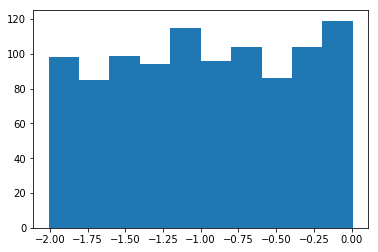

In [9]:
vals = torch.Tensor(1, dim).uniform_(-2.01,0.01)   # <========= Define Initialization Scheme/Point

for p in list(SGD_model.parameters()):
    p.data = torch.Tensor(vals)
    
# Visualize Weight Initialization    
h = np.asarray(SGD_model.linear.weight.data.numpy())
h = h.transpose()
h.shape

plt.hist(h)
plt.show()

##### --> Optimizers

In [10]:
# Define hyperparameters
l_rate    = 1e-2
precision = 1
N         = 5
gamma_ex  = 1e-2

# optimizers
SGD       = torch.optim.SGD(SGD_model.parameters(), lr=l_rate) #Stochastic Gradient Descent
Vprop     = Vprop(Vprop_model.parameters(), alpha=0.9999, precision=precision, lr=l_rate)
noisyAdam = noisyAdam(noisyAdam_model.parameters(), num_examples=N, gamma_ex=gamma_ex, lr=l_rate)

##### --> Adaptive Learning Rate

In [11]:
SGD_scheduler = optim.lr_scheduler.MultiStepLR(SGD, milestones=[10,30], gamma=0.1)

### 6. Train Model

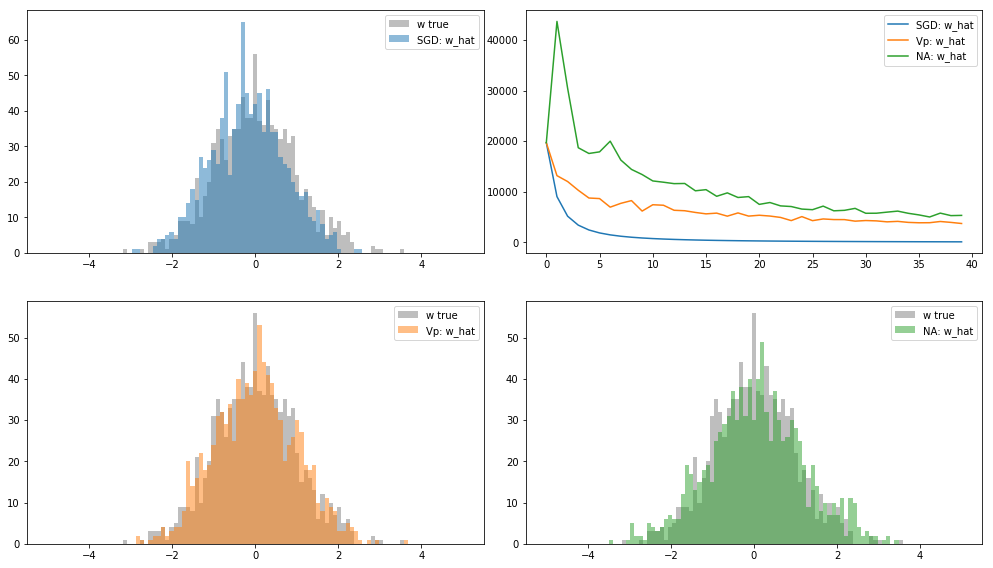

epoch 40, SGD loss 110.32505798339844
epoch 40, Vpp loss 3734.251953125
epoch 40, Nad loss 5336.50390625


In [12]:
epochs = 40
losses_sg = []
losses_vp = []
losses_na = []
plt.figure()

for epoch in range(epochs):

    epoch +=1
    inputs  = Variable(torch.from_numpy(X))
    targets = Variable(torch.from_numpy(y))

    # sample
    Vprop.sample(init_point=vals)
    noisyAdam.sample(init_point=vals)
    
    # forward pass
    SGD.zero_grad()
    Vprop.zero_grad()
    noisyAdam.zero_grad()
    
    outputs_sg = SGD_model.forward(inputs)
    outputs_vp = Vprop_model.forward(inputs)
    outputs_na = noisyAdam_model.forward(inputs)

    
    # backprop & update
    loss_sg = criterion(outputs_sg, targets)
    loss_vp = criterion(outputs_vp, targets)
    loss_na = criterion(outputs_na, targets)
    
    loss_sg.backward()
    loss_vp.backward()
    loss_na.backward()
    
    SGD.step()
    Vprop.step()
    noisyAdam.step()
    
    # adapt lr
    #SGD_scheduler.step()
    
    """______ Plots _____"""
    
    # extract weights
    w_hat_sg = get_weights(SGD_model)
    w_hat_vp = get_weights(Vprop_model)
    w_hat_na = get_weights(noisyAdam_model)
    models_weights = [w_hat_sg, w_hat_vp, w_hat_na]
    
    # collect losses
    losses_sg.append(loss_sg)
    losses_vp.append(loss_vp)
    losses_na.append(loss_na)
    losses = [losses_sg, losses_vp, losses_na]
    
    plot_dist(w, [np.asarray(x).reshape(-1) for x in models_weights], \
              losses = [np.asarray(x).reshape(-1) for x in losses], \
              labels = ['SGD: w_hat', 'Vp: w_hat', 'NA: w_hat'], num_models=3)
    
    print('epoch {}, SGD loss {}'.format(epoch, loss_sg.data[0]))
    print('epoch {}, Vpp loss {}'.format(epoch, loss_vp.data[0]))
    print('epoch {}, Nad loss {}'.format(epoch, loss_na.data[0]))

### Aki: Yes, But did it work?

In [21]:
S = 100 #number of samples
q_samples  = np.ndarray((dim, S))
nll_losses = np.ndarray(S)
for i in range(S):
    inputs  = Variable(torch.from_numpy(X))
    targets = Variable(torch.from_numpy(y))

    # sample
    params = noisyAdam.sample()
    q_samples[:,i] = get_weights2(noisyAdam_model)
    
    # forward pass
    outputs_na = noisyAdam_model.forward(inputs)
    
    # compute nll loss
    loss = criterion(outputs_na, targets)
    nll_losses[i] = loss.data[0]
    

# Extracting mu and sigma from dict
q_mu    =[]
q_sigma =[]
for key, value in params.items():
    if "mu" in key:
        q_mu.extend(value.numpy())
    elif "sigma" in key:
        q_sigma.extend(value.numpy())
    else:
        print("Parameter ", key, "was not stored")

# Running Diagnostic
_, _ = psis_diagnostic(num_samples=S, q_samples=q_samples, q_mu=q_mu, q_simga=q_sigma, NLL=nll_losses)    

(1000, 100)
PSIS K value is:  [1.96590498 1.92120525 2.20112877 2.45610142 2.45523506 4.17452403
 3.4394495  2.58327886 3.79148852 1.70873183 2.1339578  2.39425911
 2.0825938  3.29966047 2.60331552 1.85014867 2.51230625 2.86767832
 2.25471425 3.757339   2.19710467 1.82033551 2.91548834 2.02310863
 3.6759995  2.70356965 1.84622169 2.44613043 2.28074176 4.46914505
 4.5537766  3.59213076 2.43500891 2.44234587 1.86571971 1.62393735
 3.09557022 2.05757978 1.76141749 1.80285294 1.88360122 2.11021537
 2.04463415 2.63861154 2.16112354 3.05471772 4.09159276 1.99611833
 2.02621002 1.85491663 2.09571834 2.41464236 2.26155607 2.03807544
 3.08581791 1.96643355 2.12531021 2.90746596 2.11969811 2.55728028
 1.68207143 2.5841948  2.77068287 3.47084924 2.58622472 1.52936703
 2.42122739 2.12479856 2.1634969  2.16734055 1.91880292 2.29873046
 2.15591591 2.4485954  4.50988601 2.32619142 1.91548057 2.08784239
 2.53125784 3.567326   2.11658212 2.78071766 3.97726352 2.43315604
 1.78880353 2.35047886 2.2940990

In [16]:
q_samples.shape

(1000, 100)

In [ ]:
test = get_weights2(noisyAdam_model)
type(test)

In [ ]:
nll_losses[1].shape

In [15]:
type(q_samples)

numpy.ndarray